# Post-Processing (General)

#### Updated: Aug 3, 2023

#  

Post-processing pipeline after stage 2 of Alouette processing (OCR processing stage):

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

In [190]:
rootDir = 'L:/DATA/Alouette_I/BATCH_I_Run2/'
processedDir = rootDir + '04_processed/'
resultDir = rootDir + '05_result/'
logDir = rootDir + '06_log/'

#  

#### Functions:

In [191]:
def construct_timestamp(df_in):
    
    df_in['time_quality'] = 0
    
    #To the nearest second (time quality 1)
    df_in['month_day'] = pd.to_datetime(df_in['day_of_year'], format='%j').dt.strftime('%m-%d')
    df_in['month'] = df_in['month_day'].str.split('-').str[0]
    df_in['day'] = df_in['month_day'].str.split('-').str[1]
    df_in['Timestamp'] = pd.to_datetime(df_in[['year', 'month', 'day', 'hour', 'minute', 'second']], format='%Y-%m-%d %H:%M:%S')
    df_in.loc[~df_in['Timestamp'].isnull(), 'time_quality'] = 1
    df_in_tq1 = df_in.loc[df_in['time_quality'] == 1]
    
    #To the nearest minute (time quality 2)
    df_in_not_tq1 = df_in.loc[df_in['time_quality'] != 1]
    df_in_not_tq1 = df_in_not_tq1.copy(deep=True)
    df_in_not_tq1['Timestamp'] = pd.to_datetime(df_in_not_tq1[['year', 'month', 'day', 'hour', 'minute']], format='%Y-%m-%d %H:%M:00')
    df_in_not_tq1.loc[~df_in_not_tq1['Timestamp'].isnull(), 'time_quality'] = 2
    df_in_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] == 2]
    
    #To the nearest hour (time quality 3)
    df_in_not_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] != 2]
    df_in_not_tq2 = df_in_not_tq2.copy(deep=True)
    df_in_not_tq2['Timestamp'] = pd.to_datetime(df_in_not_tq2[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H:00:00')
    df_in_not_tq2.loc[~df_in_not_tq2['Timestamp'].isnull(), 'time_quality'] = 3
    df_in_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] == 3]
    
    #To the nearest day (time quality 4)
    df_in_not_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] != 3]
    df_in_not_tq3 = df_in_not_tq3.copy(deep=True)
    df_in_not_tq3['Timestamp'] = pd.to_datetime(df_in_not_tq3[['year', 'month', 'day']], format='%Y-%m-%d 00:00:00')
    df_in_not_tq3.loc[~df_in_not_tq3['Timestamp'].isnull(), 'time_quality'] = 4
    df_in_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] == 4]
    
    df_in_not_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] != 4]
    df_in = pd.concat([df_in_tq1, df_in_tq2, df_in_tq3, df_in_tq4, df_in_not_tq4])
    
    return df_in

#  

#### Generate processed_inventory, concatenate stage 1 results - RUN BEFORE starting stage 2 processing (OCR processing stage):

Generate processed_inventory:

In [ ]:
df_inventory = pd.DataFrame()
for directory in os.listdir(processedDir):
    print(directory)
    for subdirectory in os.listdir(processedDir + directory):
        n_images = len(os.listdir(processedDir + directory + '/' + subdirectory))
        df_inventory_ = pd.DataFrame({
            'Directory': directory, 
            'Subdirectory': subdirectory,
            'images': n_images,
            'subdir_id': directory + '_' + subdirectory
        }, index=[0])
        df_inventory = pd.concat([df_inventory, df_inventory_], axis=0, ignore_index=True)

In [ ]:
print(len(df_inventory))
df_inventory.head()

In [ ]:
df_inventory.to_csv(logDir + 'image_inventory_processed.csv', index=False)

Concatenate stage 1 results:

In [ ]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result-' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[1].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv', low_memory=False)
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                    df_load = pd.DataFrame()
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)

In [ ]:
df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv')
print(len(df_result))
df_result.sample(10)

#  

#### Concatenate 'OCR pass' results - START HERE after stage 2 processeing (OCR processing stage):

In [ ]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result_OCRpass' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[2].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)

#  

#### Reduce columns:

In [192]:
df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
print(len(df_result))
df_result.head()

208729


,fmin,max_depth,satellite_number,year,day_1,day_2,day_3,hour_1,hour_2,minute_1,...,filename,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,station_code,station_number,rotated_metadata
0,1.5,387.500000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,10.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.5,504.166667,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,100.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.5,556.250000,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,101.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.5,654.166667,0.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0,...,102.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.5,556.250000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,103.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
df_result['year_1'] = df_result['year']
df_result = df_result[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 
                       'station_number', 'station_number_1', 'station_number_2', 'year_1', 'day_1', 'day_2', 'day_3', 
                       'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'satellite_number', 
                       'station_number_OCR', 'year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR', 
                       'metadata_type', 'is_dot', 'func_name', 'details']] 
df_result.sample(10)

,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,metadata_type,is_dot,func_name,details
131150,R014207841,3099-8B,139.png,num2,1.741935,1256.862745,NaN,NaN,NaN,NaN,...,8.0,65.0,214,03,46,10,NaN,NaN,NaN,NaN
198782,R014207908F,558,Image0100.png,num,1.512097,1356.818182,NaN,0.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153625,R014207842,3301-15A,9.png,loss,1.500000,1237.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
203015,R014207908F,569,Image0314.png,num,1.596774,1302.272727,NaN,0.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90307,R014207832,3618-43-2,18.png,loss,1.500000,1478.947368,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
54851,R014207823,3556-43,105.png,loss,1.633065,1347.916667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
6078,R014207815,3508-A19,320.png,num,1.697581,1365.957447,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193379,R014207907F,544,Image0079.png,dot,1.552419,1359.090909,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62999,R014207823,3584-38A,48.png,loss,8.871951,791.666667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
110797,R014207840,3028-50A,135.png,num2,1.500000,710.416667,NaN,NaN,NaN,NaN,...,50,65,330.0,01,32,50,NaN,NaN,NaN,NaN


#  

#### Split results into different metadata types (dot, num, num2):

In [194]:
df_result['processed_image_class'].unique()

array(['num', 'loss', 'outlier', 'num2', 'dot'], dtype=object)

In [195]:
df_num2 = df_result.loc[df_result['processed_image_class'] == 'num2']
print(len(df_num2))

39034


In [196]:
df_num = df_result.loc[df_result['processed_image_class'] == 'num']
print(len(df_num))

38415


In [197]:
df_dot = df_result.loc[df_result['processed_image_class'] == 'dot']
print(len(df_dot))

13239


In [198]:
df_outlier = df_result.loc[df_result['processed_image_class'] == 'outlier']
print(len(df_outlier))

5451


In [199]:
df_loss = df_result.loc[df_result['processed_image_class'] == 'loss']
print(len(df_loss))

112590


In [200]:
len(df_num2) + len(df_num) + len(df_dot) + len(df_outlier) + len(df_loss)

208729

#### num2 - check timestamp components, construct timestamp:

In [201]:
df_num2[['year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR']].sample(10)

,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
132296,65.0,283.0,2.0,21,49.0
52693,66.0,129.0,13.0,5.0,55.0
84020,65.0,219.0,16.0,42.0,48
36492,65.0,228.0,18.0,23,56
34435,66.0,14.0,05,40,09
32046,66.0,105,15,51,19
33658,66,067,18.0,24,41
78096,65.0,228.0,11,43,06
148047,65.0,290.0,01,20,13.0
51784,65.0,353.0,11,42,31


year:

<AxesSubplot:xlabel='year_OCR', ylabel='Count'>

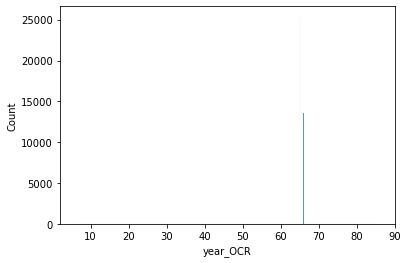

In [202]:
df_num2 = df_num2.copy(deep=True)
df_num2['year_OCR'] = df_num2['year_OCR'].astype('float')
sns.histplot(data=df_num2, x='year_OCR')

In [203]:
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x<62 else x)
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x>80 else x)

In [204]:
df_num2['year'] = df_num2['year_OCR'] + 1900
df_num2[['year', 'year_OCR']].sample(10)

,year,year_OCR
79347,1965.0,65.0
142672,1966.0,66.0
36702,1965.0,65.0
146327,1965.0,65.0
154358,1965.0,65.0
48341,1965.0,65.0
63160,1966.0,66.0
149021,1965.0,65.0
147541,1965.0,65.0
36326,1965.0,65.0


day:

<AxesSubplot:xlabel='day_of_year_OCR', ylabel='Count'>

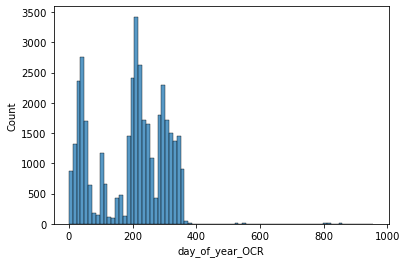

In [205]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].astype('float')
sns.histplot(data=df_num2, x='day_of_year_OCR')

In [206]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x>366 else x)
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x==0 else x)
df_num2['day_of_year'] = df_num2['day_of_year_OCR']
df_num2[['day_of_year', 'day_of_year_OCR']].sample(10)

,day_of_year,day_of_year_OCR
140938,204.0,204.0
112259,312.0,312.0
19069,36.0,36.0
146905,314.0,314.0
148653,298.0,298.0
49745,310.0,310.0
150231,314.0,314.0
130011,260.0,260.0
83223,210.0,210.0
21508,335.0,335.0


hour:

<AxesSubplot:xlabel='hour_OCR', ylabel='Count'>

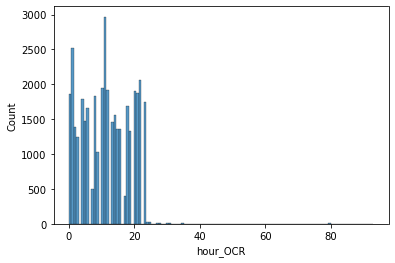

In [207]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].astype('float')
sns.histplot(data=df_num2, x='hour_OCR')

In [208]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].apply(lambda x: np.nan if x>24 else x)
df_num2['hour'] = df_num2['hour_OCR']
df_num2[['hour', 'hour_OCR']].sample(10)

,hour,hour_OCR
70134,19.0,19.0
32775,0.0,0.0
35009,5.0,5.0
42249,19.0,19.0
22861,8.0,8.0
58538,22.0,22.0
146777,22.0,22.0
104296,17.0,17.0
152208,8.0,8.0
149715,10.0,10.0


minute:

<AxesSubplot:xlabel='minute_OCR', ylabel='Count'>

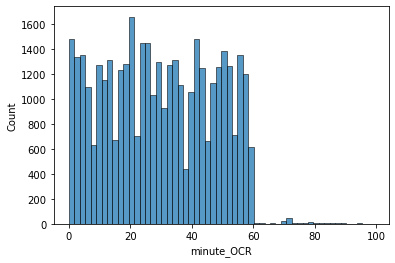

In [209]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].astype('float')
sns.histplot(data=df_num2, x='minute_OCR')

In [210]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['minute'] = df_num2['minute_OCR']
df_num2[['minute', 'minute_OCR']].sample(10)

,minute,minute_OCR
26927,46.0,46.0
23815,1.0,1.0
64393,22.0,22.0
155040,35.0,35.0
152172,55.0,55.0
154715,46.0,46.0
146285,56.0,56.0
139830,23.0,23.0
51431,12.0,12.0
149085,26.0,26.0


second:

<AxesSubplot:xlabel='second_OCR', ylabel='Count'>

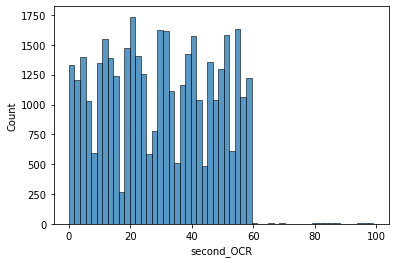

In [211]:
df_num2['second_OCR'] = df_num2['second_OCR'].astype('float')
sns.histplot(data=df_num2, x='second_OCR')

In [212]:
df_num2['second_OCR'] = df_num2['second_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['second'] = df_num2['second_OCR']
df_num2[['second', 'second_OCR']].sample(10)

,second,second_OCR
101850,59.0,59.0
32824,39.0,39.0
17874,22.0,22.0
22756,21.0,21.0
148626,31.0,31.0
124261,54.0,54.0
41049,56.0,56.0
145405,33.0,33.0
25038,37.0,37.0
80543,40.0,40.0


construct timestamp:

In [213]:
df_num2 = construct_timestamp(df_in=df_num2)
print(len(df_num2))

39034


In [214]:
df_num2[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality', 'satellite_number']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality,satellite_number
150238,1965.0,11,10,23.0,12.0,53.0,1965-11-10 23:12:53,1,NaN
141289,1965.0,07,24,11.0,51.0,40.0,1965-07-24 11:51:40,1,NaN
57073,1966.0,06,10,6.0,42.0,54.0,1966-06-10 06:42:54,1,NaN
143791,1966.0,02,01,10.0,1.0,53.0,1966-02-01 10:01:53,1,NaN
155246,1965.0,07,31,5.0,45.0,34.0,1965-07-31 05:45:34,1,NaN
142115,1966.0,02,05,22.0,4.0,20.0,1966-02-05 22:04:20,1,NaN
105402,1965.0,11,17,20.0,5.0,44.0,1965-11-17 20:05:44,1,NaN
75639,1965.0,07,26,12.0,47.0,46.0,1965-07-26 12:47:46,1,NaN
72572,1965.0,07,09,5.0,19.0,31.0,1965-07-09 05:19:31,1,NaN
98567,1966.0,05,30,12.0,25.0,53.0,1966-05-30 12:25:53,1,NaN


#  

#### num - check satellite number, check timestamp components, construct timestamp:

Filter for satellite_number == 1:

In [215]:
print(len(df_num))
df_num = df_num.loc[df_num['satellite_number'] == 1]
print(len(df_num))
df_num.head()

38415
22763


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,metadata_type,is_dot,func_name,details
0,R014207815,3488-15A,10.png,num,1.5,387.500000,NaN,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R014207815,3488-15A,101.png,num,1.5,556.250000,NaN,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,R014207815,3488-15A,11.png,num,1.5,347.916667,NaN,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,R014207815,3488-15A,111.png,num,1.5,504.166667,NaN,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,R014207815,3488-15A,114.png,num,1.5,504.166667,NaN,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check timestamp components, construct timestamp:

In [216]:
df_num[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2
197456,3.0,0.0,2.0,0.0,1.0,6.0,2.0,7.0,5.0,5.0
137478,0.0,2.0,1.0,0.0,5.0,0.0,2.0,2.0,2.0,4.0
100232,1.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,3.0
177988,2.0,3.0,1.0,3.0,2.0,2.0,5.0,7.0,2.0,8.0
184001,3.0,0.0,2.0,1.0,1.0,4.0,1.0,7.0,1.0,9.0
7156,2.0,1.0,3.0,2.0,3.0,3.0,3.0,3.0,5.0,2.0
186065,2.0,3.0,2.0,6.0,5.0,5.0,4.0,2.0,1.0,1.0
135374,3.0,1.0,0.0,3.0,2.0,2.0,2.0,2.0,4.0,2.0
201823,3.0,0.0,3.0,4.0,0.0,3.0,5.0,0.0,0.0,4.0
161182,3.0,0.0,4.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0


year - adjust to baseline 1962:

<AxesSubplot:xlabel='year', ylabel='Count'>

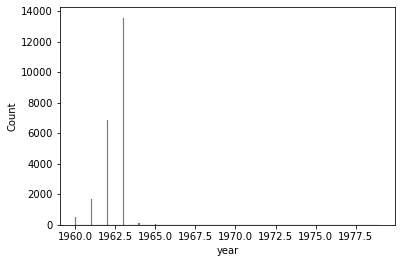

In [217]:
df_num = df_num.copy(deep=True)
df_num['year'] = df_num['year_1'] + 1960 #1962
df_num['year'] = df_num['year'].astype('float')
sns.histplot(data=df_num, x='year')

In [218]:
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x<1962 else x)
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x>1980 else x)
df_num[['year', 'year_1']].sample(10)

,year,year_1
185053,1962.0,2.0
180842,1962.0,2.0
192875,1963.0,3.0
178134,1962.0,2.0
205178,1963.0,3.0
193209,1963.0,3.0
199737,1963.0,3.0
189688,1962.0,2.0
200207,1962.0,2.0
189599,1962.0,2.0


day:

<AxesSubplot:xlabel='day_1', ylabel='Count'>

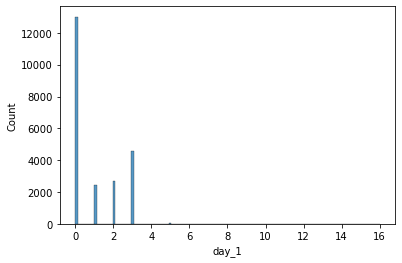

In [219]:
df_num['day_1'] = df_num['day_1'].astype(int)
sns.histplot(data=df_num, x='day_1')

In [220]:
df_num['day_1'] = df_num['day_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='day_2', ylabel='Count'>

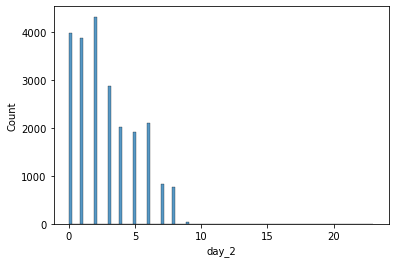

In [221]:
df_num['day_2'] = df_num['day_2'].astype(int)
sns.histplot(data=df_num, x='day_2')

In [222]:
df_num['day_2'] = df_num['day_2'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='day_3', ylabel='Count'>

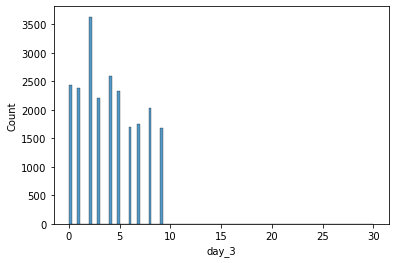

In [223]:
df_num['day_3'] = df_num['day_3'].astype(int)
sns.histplot(data=df_num, x='day_3')

In [224]:
df_num['day_3'] = df_num['day_3'].apply(lambda x: np.nan if x>9 else x)

In [225]:
df_num_daycheck = df_num[~pd.isna(df_num['day_1'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_2'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_3'])]
df_num_daycheck['day_of_year'] = df_num_daycheck['day_1'].astype(int).astype(str) + df_num_daycheck['day_2'].astype(int).astype(str) + df_num_daycheck['day_3'].astype(int).astype(str)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].astype(int)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_num_nullday = df_num.loc[pd.isna(df_num['day_1']) | pd.isna(df_num['day_2']) | pd.isna(df_num['day_3'])]
df_num_nullday = df_num_nullday.copy(deep=True)
df_num_nullday['day_of_year'] = np.nan
df_num = pd.concat([df_num_daycheck, df_num_nullday])
print(len(df_num))
df_num[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

22763


,day_of_year,day_1,day_2,day_3
192381,5.0,0.0,0.0,5.0
203388,37.0,0.0,3.0,7.0
189571,360.0,3.0,6.0,0.0
190941,364.0,3.0,6.0,4.0
199193,29.0,0.0,2.0,9.0
201920,34.0,0.0,3.0,4.0
199087,27.0,0.0,2.0,7.0
198901,28.0,0.0,2.0,8.0
5258,112.0,1.0,1.0,2.0
205656,42.0,0.0,4.0,2.0


hour:

<AxesSubplot:xlabel='hour_1', ylabel='Count'>

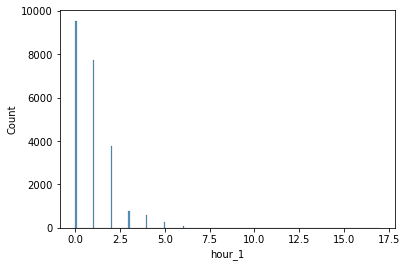

In [226]:
df_num['hour_1'] = df_num['hour_1'].astype(int)
sns.histplot(data=df_num, x='hour_1')

In [227]:
df_num['hour_1'] = df_num['hour_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='hour_2', ylabel='Count'>

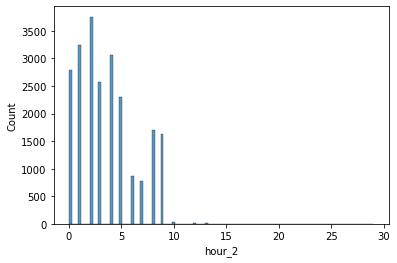

In [228]:
df_num['hour_2'] = df_num['hour_2'].astype(int)
sns.histplot(data=df_num, x='hour_2')

In [229]:
df_num['hour_2'] = df_num['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [230]:
df_num_hourcheck = df_num[~pd.isna(df_num['hour_1'])]
df_num_hourcheck = df_num_hourcheck[~pd.isna(df_num_hourcheck['hour_2'])]
df_num_hourcheck['hour'] = df_num_hourcheck['hour_1'].astype(int).astype(str) + df_num_hourcheck['hour_2'].astype(int).astype(str)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].astype(int)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_num_nullhour = df_num.loc[pd.isna(df_num['hour_1']) | pd.isna(df_num['hour_2'])]
df_num_nullhour = df_num_nullhour.copy(deep=True)
df_num_nullhour['hour'] = np.nan
df_num = pd.concat([df_num_hourcheck, df_num_nullhour])
print(len(df_num))
df_num[['hour', 'hour_1', 'hour_2']].sample(10)

22763


,hour,hour_1,hour_2
5257,NaN,3.0,2.0
205178,5.0,0.0,5.0
207284,6.0,0.0,6.0
208503,2.0,0.0,2.0
275,11.0,1.0,1.0
133889,NaN,3.0,6.0
182296,15.0,1.0,5.0
74129,4.0,0.0,4.0
203362,12.0,1.0,2.0
84789,11.0,1.0,1.0


minute:

<AxesSubplot:xlabel='minute_1', ylabel='Count'>

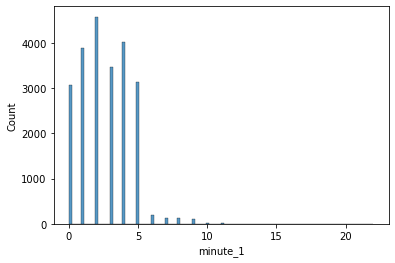

In [231]:
df_num['minute_1'] = df_num['minute_1'].astype(int)
sns.histplot(data=df_num, x='minute_1')

In [232]:
df_num['minute_1'] = df_num['minute_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='minute_2', ylabel='Count'>

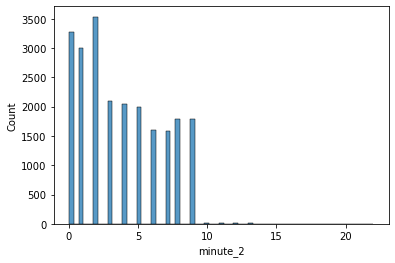

In [233]:
df_num['minute_2'] = df_num['minute_2'].astype(int)
sns.histplot(data=df_num, x='minute_2')

In [234]:
df_num['minute_2'] = df_num['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [235]:
df_num_mincheck = df_num[~pd.isna(df_num['minute_1'])]
df_num_mincheck = df_num_mincheck[~pd.isna(df_num_mincheck['minute_2'])]
df_num_mincheck['minute'] = df_num_mincheck['minute_1'].astype(int).astype(str) + df_num_mincheck['minute_2'].astype(int).astype(str)
df_num_mincheck['minute'] = df_num_mincheck['minute'].astype(int)
df_num_mincheck['minute'] = df_num_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_num_nullmin = df_num.loc[pd.isna(df_num['minute_1']) | pd.isna(df_num['minute_2'])]
df_num_nullmin = df_num_nullmin.copy(deep=True)
df_num_nullmin['minute'] = np.nan
df_num = pd.concat([df_num_mincheck, df_num_nullmin])
print(len(df_num))
df_num[['minute', 'minute_1', 'minute_2']].sample(10)

22763


,minute,minute_1,minute_2
199739,57.0,5.0,7.0
199344,27.0,2.0,7.0
192932,41.0,4.0,1.0
197363,36.0,3.0,6.0
5452,40.0,4.0,0.0
84284,11.0,1.0,1.0
128853,42.0,4.0,2.0
187812,39.0,3.0,9.0
208596,54.0,5.0,4.0
202669,16.0,1.0,6.0


second:

<AxesSubplot:xlabel='second_1', ylabel='Count'>

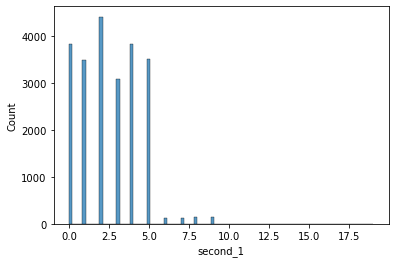

In [236]:
df_num['second_1'] = df_num['second_1'].astype(int)
sns.histplot(data=df_num, x='second_1')

In [237]:
df_num['second_1'] = df_num['second_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='second_2', ylabel='Count'>

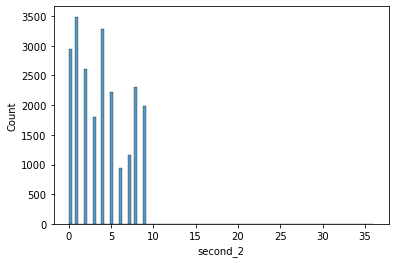

In [238]:
df_num['second_2'] = df_num['second_2'].astype(int)
sns.histplot(data=df_num, x='second_2')

In [239]:
df_num['second_2'] = df_num['second_2'].apply(lambda x: np.nan if x>9 else x)

In [240]:
df_num_seccheck = df_num[~pd.isna(df_num['second_1'])]
df_num_seccheck = df_num_seccheck[~pd.isna(df_num_seccheck['second_2'])]
df_num_seccheck['second'] = df_num_seccheck['second_1'].astype(int).astype(str) + df_num_seccheck['second_2'].astype(int).astype(str)
df_num_seccheck['second'] = df_num_seccheck['second'].astype(int)
df_num_seccheck['second'] = df_num_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_num_nullsec = df_num.loc[pd.isna(df_num['second_1']) | pd.isna(df_num['second_2'])]
df_num_nullsec = df_num_nullsec.copy(deep=True)
df_num_nullsec['second'] = np.nan
df_num = pd.concat([df_num_seccheck, df_num_nullsec])
print(len(df_num))
df_num[['second', 'second_1', 'second_2']].sample(10)

22763


,second,second_1,second_2
182330,55.0,5.0,5.0
7197,23.0,2.0,3.0
180973,36.0,3.0,6.0
192409,30.0,3.0,0.0
84174,12.0,1.0,2.0
201626,34.0,3.0,4.0
184108,35.0,3.0,5.0
83795,23.0,2.0,3.0
186905,55.0,5.0,5.0
174796,37.0,3.0,7.0


construct timestamp:

In [241]:
df_num = construct_timestamp(df_in=df_num)
print(len(df_num))

22763


In [242]:
df_num[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality', 'satellite_number']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality,satellite_number
179474,1962.0,10,01,15.0,24.0,28.0,1962-10-01 15:24:28,1,1.0
196453,1963.0,01,17,5.0,35.0,12.0,1963-01-17 05:35:12,1,1.0
196922,1963.0,01,18,9.0,47.0,19.0,1963-01-18 09:47:19,1,1.0
205067,1963.0,02,10,13.0,42.0,56.0,1963-02-10 13:42:56,1,1.0
196407,1963.0,01,16,15.0,49.0,4.0,1963-01-16 15:49:04,1,1.0
198302,1963.0,01,25,9.0,4.0,45.0,1963-01-25 09:04:45,1,1.0
4792,1963.0,11,18,NaN,33.0,34.0,1963-11-18 00:00:00,4,1.0
182119,1963.0,01,09,NaN,51.0,55.0,1963-01-09 00:00:00,4,1.0
192202,1963.0,01,04,9.0,54.0,48.0,1963-01-04 09:54:48,1,1.0
189439,1962.0,12,25,10.0,36.0,48.0,1962-12-25 10:36:48,1,1.0


#  

#### dot - check satellite number, check timestamp components, construct timestamp:

Check satellite number:

In [243]:
df_dot['satellite_number'].unique()

array([nan])

- it appears that satellite_number does not get read in Stage 1 processing.

Check timestamp components, construct timestamp:

In [244]:
df_dot = df_dot.copy(deep=True)
df_dot[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'is_dot', 'satellite_number']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2,is_dot,satellite_number
176870,NaN,0.0,2.0,3.0,0.0,0.0,1.0,2.0,0.0,4.0,NaN,NaN
191736,NaN,4.0,6.0,6.0,4.0,3.0,2.0,5.0,0.0,7.0,NaN,NaN
174221,NaN,16.0,4.0,8.0,8.0,8.0,8.0,20.0,0.0,1.0,NaN,NaN
175088,NaN,12.0,1.0,10.0,13.0,1.0,0.0,9.0,1.0,5.0,NaN,NaN
181314,NaN,0.0,0.0,8.0,8.0,0.0,10.0,4.0,4.0,12.0,NaN,NaN
182643,NaN,0.0,0.0,8.0,10.0,0.0,1.0,0.0,14.0,2.0,NaN,NaN
174443,NaN,16.0,4.0,16.0,8.0,8.0,12.0,20.0,8.0,1.0,NaN,NaN
184283,NaN,16.0,8.0,12.0,8.0,16.0,10.0,9.0,8.0,8.0,NaN,NaN
194185,NaN,0.0,16.0,0.0,0.0,12.0,14.0,4.0,12.0,9.0,NaN,NaN
187446,NaN,8.0,2.0,12.0,8.0,1.0,12.0,12.0,2.0,10.0,NaN,NaN


day:

<AxesSubplot:xlabel='day_1', ylabel='Count'>

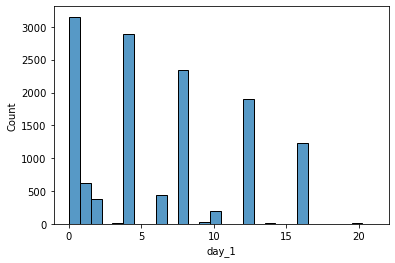

In [245]:
df_dot['day_1'] = df_dot['day_1'].astype(int)
sns.histplot(data=df_dot, x='day_1')

In [246]:
df_dot['day_1'] = df_dot['day_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='day_2', ylabel='Count'>

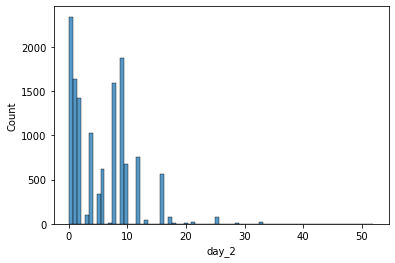

In [247]:
df_dot['day_2'] = df_dot['day_2'].astype(int)
sns.histplot(data=df_dot, x='day_2')

In [248]:
df_dot['day_2'] = df_dot['day_2'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='day_3', ylabel='Count'>

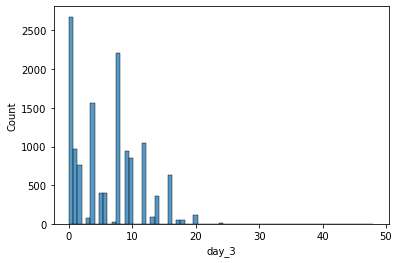

In [249]:
df_dot['day_3'] = df_dot['day_3'].astype(int)
sns.histplot(data=df_dot, x='day_3')

In [250]:
df_dot['day_3'] = df_dot['day_3'].apply(lambda x: np.nan if x>9 else x)

In [251]:
df_dot_daycheck = df_dot[~pd.isna(df_dot['day_1'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_2'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_3'])]
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_1'].astype(int).astype(str) + df_dot_daycheck['day_2'].astype(int).astype(str) + df_dot_daycheck['day_3'].astype(int).astype(str)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].astype(int)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_dot_nullday = df_dot.loc[pd.isna(df_dot['day_1']) | pd.isna(df_dot['day_2']) | pd.isna(df_dot['day_3'])]
df_dot_nullday = df_dot_nullday.copy(deep=True)
df_dot_nullday['day_of_year'] = np.nan
df_dot = pd.concat([df_dot_daycheck, df_dot_nullday])
print(len(df_dot))
df_dot[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

13239


,day_of_year,day_1,day_2,day_3
177126,25.0,0.0,2.0,5.0
174412,NaN,NaN,1.0,NaN
184130,NaN,0.0,NaN,8.0
188931,NaN,4.0,9.0,8.0
179922,NaN,0.0,0.0,0.0
176885,230.0,2.0,3.0,0.0
194023,NaN,4.0,9.0,9.0
190295,NaN,8.0,NaN,8.0
188097,NaN,4.0,1.0,1.0
195876,NaN,NaN,0.0,2.0


year - infer from day:

In [252]:
df_dot['year'] = np.nan
for i in range(0, len(df_dot)):
    day = df_dot['day_of_year'].iloc[i]
    if (day < 366) & (day > 0):
        if day > 271:
            df_dot['year'].iloc[i] = 1962
        else:
            df_dot['year'].iloc[i] = 1963
df_dot[['year', 'day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

c:\DevSoftware\Anaconda38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,year,day_of_year,day_1,day_2,day_3
177089,NaN,NaN,0.0,4.0,NaN
181074,NaN,NaN,8.0,8.0,0.0
180060,NaN,NaN,NaN,8.0,0.0
188751,NaN,NaN,4.0,9.0,0.0
180535,1963.0,8.0,0.0,0.0,8.0
184761,NaN,NaN,8.0,2.0,8.0
179980,NaN,NaN,0.0,0.0,0.0
188819,NaN,NaN,4.0,9.0,0.0
191705,NaN,NaN,4.0,NaN,6.0
172721,NaN,NaN,NaN,0.0,NaN


hour:

<AxesSubplot:xlabel='hour_1', ylabel='Count'>

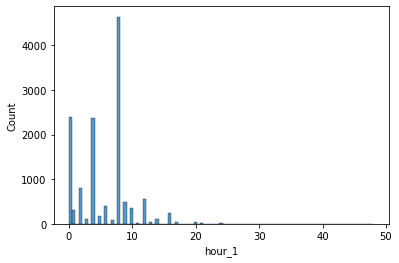

In [253]:
df_dot['hour_1'] = df_dot['hour_1'].astype(int)
sns.histplot(data=df_dot, x='hour_1')

In [254]:
df_dot['hour_1'] = df_dot['hour_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='hour_2', ylabel='Count'>

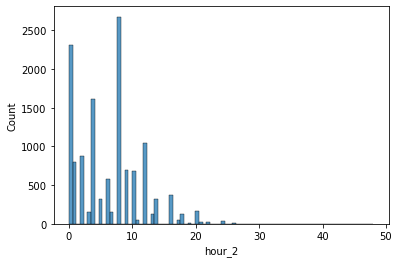

In [255]:
df_dot['hour_2'] = df_dot['hour_2'].astype(int)
sns.histplot(data=df_dot, x='hour_2')

In [256]:
df_dot['hour_2'] = df_dot['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [257]:
df_dot_hourcheck = df_dot[~pd.isna(df_dot['hour_1'])]
df_dot_hourcheck = df_dot_hourcheck[~pd.isna(df_dot_hourcheck['hour_2'])]
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour_1'].astype(int).astype(str) + df_dot_hourcheck['hour_2'].astype(int).astype(str)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].astype(int)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_dot_nullhour = df_dot.loc[pd.isna(df_dot['hour_1']) | pd.isna(df_dot['hour_2'])]
df_dot_nullhour = df_dot_nullhour.copy(deep=True)
df_dot_nullhour['hour'] = np.nan
df_dot = pd.concat([df_dot_hourcheck, df_dot_nullhour])
print(len(df_dot))
df_dot[['hour', 'hour_1', 'hour_2']].sample(10)

13239


,hour,hour_1,hour_2
188761,NaN,0.0,NaN
185767,NaN,8.0,8.0
189861,NaN,8.0,8.0
183377,NaN,0.0,NaN
174918,NaN,8.0,NaN
176435,4.0,0.0,4.0
181814,1.0,0.0,1.0
190040,NaN,8.0,NaN
185806,NaN,NaN,NaN
183631,NaN,8.0,NaN


minute:

<AxesSubplot:xlabel='minute_1', ylabel='Count'>

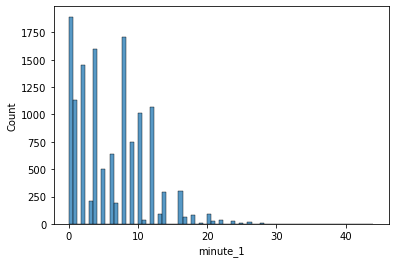

In [258]:
df_dot['minute_1'] = df_dot['minute_1'].astype(int)
sns.histplot(data=df_dot, x='minute_1')

In [259]:
df_dot['minute_1'] = df_dot['minute_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='minute_2', ylabel='Count'>

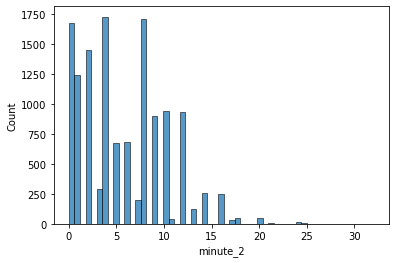

In [260]:
df_dot['minute_2'] = df_dot['minute_2'].astype(int)
sns.histplot(data=df_dot, x='minute_2')

In [261]:
df_dot['minute_2'] = df_dot['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [262]:
df_dot_mincheck = df_dot[~pd.isna(df_dot['minute_1'])]
df_dot_mincheck = df_dot_mincheck[~pd.isna(df_dot_mincheck['minute_2'])]
df_dot_mincheck['minute'] = df_dot_mincheck['minute_1'].astype(int).astype(str) + df_dot_mincheck['minute_2'].astype(int).astype(str)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].astype(int)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullmin = df_dot.loc[pd.isna(df_dot['minute_1']) | pd.isna(df_dot['minute_2'])]
df_dot_nullmin = df_dot_nullmin.copy(deep=True)
df_dot_nullmin['minute'] = np.nan
df_dot = pd.concat([df_dot_mincheck, df_dot_nullmin])
print(len(df_dot))
df_dot[['minute', 'minute_1', 'minute_2']].sample(10)

13239


,minute,minute_1,minute_2
174526,11.0,1.0,1.0
191896,NaN,NaN,7.0
175237,1.0,0.0,1.0
186598,NaN,0.0,NaN
194052,NaN,NaN,NaN
188055,4.0,0.0,4.0
188121,NaN,NaN,4.0
180130,29.0,2.0,9.0
175345,NaN,8.0,NaN
176278,NaN,2.0,NaN


second:

<AxesSubplot:xlabel='second_1', ylabel='Count'>

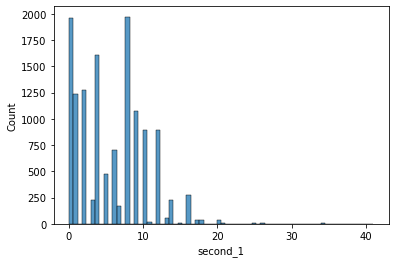

In [263]:
df_dot['second_1'] = df_dot['second_1'].astype(int)
sns.histplot(data=df_dot, x='second_1')

In [264]:
df_dot['second_1'] = df_dot['second_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='second_2', ylabel='Count'>

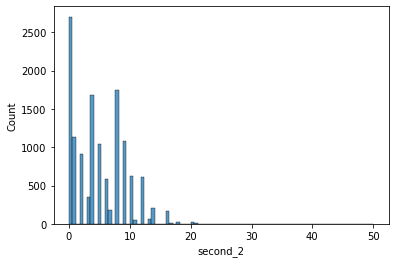

In [265]:
df_dot['second_2'] = df_dot['second_2'].astype(int)
sns.histplot(data=df_dot, x='second_2')

In [266]:
df_dot['second_2'] = df_dot['second_2'].apply(lambda x: np.nan if x>9 else x)

In [267]:
df_dot_seccheck = df_dot[~pd.isna(df_dot['second_1'])]
df_dot_seccheck = df_dot_seccheck[~pd.isna(df_dot_seccheck['second_2'])]
df_dot_seccheck['second'] = df_dot_seccheck['second_1'].astype(int).astype(str) + df_dot_seccheck['second_2'].astype(int).astype(str)
df_dot_seccheck['second'] = df_dot_seccheck['second'].astype(int)
df_dot_seccheck['second'] = df_dot_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullsec = df_dot.loc[pd.isna(df_dot['second_1']) | pd.isna(df_dot['second_2'])]
df_dot_nullsec = df_dot_nullsec.copy(deep=True)
df_dot_nullsec['second'] = np.nan
df_dot = pd.concat([df_dot_seccheck, df_dot_nullsec])
print(len(df_dot))
df_dot[['second', 'second_1', 'second_2']].sample(10)

13239


,second,second_1,second_2
190214,28.0,2.0,8.0
189301,NaN,NaN,NaN
190276,18.0,1.0,8.0
190342,18.0,1.0,8.0
203970,NaN,NaN,8.0
176534,NaN,NaN,8.0
188756,44.0,4.0,4.0
173648,NaN,9.0,0.0
181288,8.0,0.0,8.0
174475,28.0,2.0,8.0


construct timestamp:

In [268]:
df_dot = construct_timestamp(df_in=df_dot)
print(len(df_dot))

13239


In [269]:
df_dot[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality', 'satellite_number']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality,satellite_number
184664,NaN,NaN,NaN,4.0,NaN,NaN,NaT,0,NaN
175318,NaN,NaN,NaN,NaN,40.0,NaN,NaT,0,NaN
196561,1963.0,02,10,NaN,NaN,NaN,1963-02-10,4,NaN
189898,NaN,NaN,NaN,0.0,1.0,NaN,NaT,0,NaN
176662,NaN,NaN,NaN,9.0,NaN,NaN,NaT,0,NaN
195756,NaN,NaN,NaN,NaN,10.0,NaN,NaT,0,NaN
178244,NaN,NaN,NaN,NaN,18.0,0.0,NaT,0,NaN
175493,NaN,NaN,NaN,NaN,24.0,46.0,NaT,0,NaN
180440,1963.0,01,08,0.0,NaN,NaN,1963-01-08,3,NaN
193496,NaN,NaN,NaN,6.0,47.0,7.0,NaT,0,NaN


#  

#### Check station number:

num2:

<AxesSubplot:xlabel='station_number_OCR', ylabel='Count'>

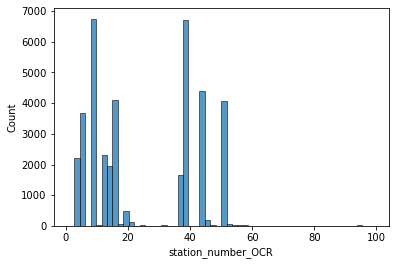

In [270]:
df_num2['station_number_OCR'] = df_num2['station_number_OCR'].astype('float')
sns.histplot(data=df_num2, x='station_number_OCR')

In [271]:
df_num2['station_number'] = df_num2['station_number_OCR']
df_num2[['station_number', 'station_number_OCR']].sample(10)

,station_number,station_number_OCR
18812,36.0,36.0
33775,50.0,50.0
143962,3.0,3.0
133159,8.0,8.0
122112,8.0,8.0
126694,8.0,8.0
1399,8.0,8.0
24006,13.0,13.0
101749,8.0,8.0
64335,50.0,50.0


num:

<AxesSubplot:xlabel='station_number_1', ylabel='Count'>

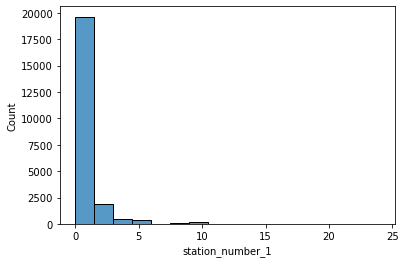

In [272]:
df_num['station_number_1'] = df_num['station_number_1'].astype(int)
sns.histplot(data=df_num, x='station_number_1')

In [273]:
df_num['station_number_1'] = df_num['station_number_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='station_number_2', ylabel='Count'>

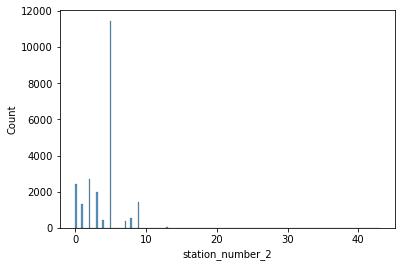

In [274]:
df_num['station_number_2'] = df_num['station_number_2'].astype(int)
sns.histplot(data=df_num, x='station_number_2')

In [275]:
df_num['station_number_2'] = df_num['station_number_2'].apply(lambda x: np.nan if x>9 else x)

In [276]:
df_num_stncheck = df_num[~pd.isna(df_num['station_number_1'])]
df_num_stncheck = df_num_stncheck[~pd.isna(df_num_stncheck['station_number_2'])]
df_num_stncheck['station_number'] = df_num_stncheck['station_number_1'].astype(int).astype(str) + df_num_stncheck['station_number_2'].astype(int).astype(str)
df_num_stncheck['station_number'] = df_num_stncheck['station_number'].astype(int)
df_num_nullstn = df_num.loc[pd.isna(df_num['station_number_1']) | pd.isna(df_num['station_number_2'])]
df_num_nullstn = df_num_nullstn.copy(deep=True)
df_num_nullstn['station_number'] = np.nan
df_num = pd.concat([df_num_stncheck, df_num_nullstn])
print(len(df_num))
df_num[['station_number', 'station_number_1', 'station_number_2']].sample(10)

22763


,station_number,station_number_1,station_number_2
135303,24.0,2.0,4.0
7222,11.0,1.0,1.0
198182,5.0,0.0,5.0
5268,23.0,2.0,3.0
198803,5.0,0.0,5.0
202661,5.0,0.0,5.0
7561,22.0,2.0,2.0
116301,35.0,3.0,5.0
196920,NaN,0.0,NaN
4664,24.0,2.0,4.0


dot:

In [277]:
df_dot[['station_number']].sample(10)

,station_number
183648,0.0
176897,12.0
181312,0.0
175761,5.0
179919,10.0
191638,6.0
188952,0.0
183652,0.0
180022,8.0
193552,4.0


#  

#### Recombine results, save:

In [278]:
df_result2 = pd.concat([df_num2, df_num, df_dot, df_outlier, df_loss])
print(len(df_result2))
df_result2.sample(10)

193077


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,year,day_of_year,hour,minute,second,time_quality,month_day,month,day,Timestamp
11868,R014207815,3526-A50,29.png,loss,1.512097,2115.625000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
192266,R014207907F,540,Image0137.png,num,1.592742,1392.857143,85.0,8.0,5.0,3.0,...,1963.0,4.0,15.0,18.0,10.0,1.0,01-04,01,04,1963-01-04 15:18:10
113245,R014207840,3035-50A,200.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
206585,R014207908F,578,Image0209.png,num,1.544355,1439.534884,5.0,0.0,5.0,3.0,...,1963.0,45.0,10.0,56.0,31.0,1.0,02-14,02,14,1963-02-14 10:56:31
27416,R014207816,3402-A13,291.png,loss,1.504032,1428.571429,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
134225,R014207841,3110-8A,211.png,loss,1.689516,813.725490,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
76994,R014207824,3153-14A,37.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
28501,R014207816,3406-A43,222.png,num2,1.629032,1334.693878,36.0,NaN,NaN,NaN,...,NaN,NaN,21.0,56.0,13.0,0.0,NaN,NaN,NaN,NaT
169979,R014207844,2937-43B,225.png,loss,1.500000,1300.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
85112,R014207824,3181-14A,119.png,loss,1.500000,846.428571,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


Save:

In [279]:
df_result2.to_csv(resultDir + 'result_postprocess_raw[1960_baseline].csv', index=False)
#df_result2.to_csv(resultDir + 'result_postprocess_raw.csv', index=False)

#  

#### Retrieve station details:

In [280]:
df_stn_nums = pd.read_excel(logDir + 'station_number_changes.xlsx')
df_stn_nums.head()

,Station_Number,Station_Code,Station_Name,Start_Date,Notes
0,1,RES,"Resolute Bay, NT, Canada",1962-09-29,Assumed start date at launch.
1,1,BPT,"Blossom Point, MD, USA",1965-07-01,NaN
2,2,PRI,"Prince Albert, SK, Canada",1962-09-29,Assumed start date at launch.
3,3,OTT,"Ottawa, Canada",1962-09-29,Assumed start date at launch.
4,3,FTM,"Fort Myers, FL, USA",1965-07-01,NaN


In [281]:
change_dates = df_stn_nums['Start_Date'].drop_duplicates().sort_values().reset_index(drop=True)
stn_nums = df_stn_nums['Station_Number'].unique()

In [282]:
#df_result_pp = pd.read_csv(resultDir + 'result_postprocess_raw.csv')
df_result2 = df_result2.loc[~pd.isna(df_result2['station_number'])]

In [283]:
df_result3 = pd.DataFrame()
for i in range(0, len(change_dates)):
    #Before the first change date - Assume there are no station numbers before launch
    if i == 0:
        print(change_dates[i])
        df_part = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))
    
    elif i > 0:
        print(change_dates[i])
        df_part_ = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_part_ = df_part_.loc[df_part_['Timestamp'] >= change_dates[i-1]]
        
        df_sns = pd.DataFrame()
        for sn in stn_nums:
            df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
            df_sn = df_sn.loc[df_sn['Start_Date'] < change_dates[i]]
            if len(df_sn) > 1:
                df_sn = df_sn.sort_values('Start_Date', ascending=False)
                df_sn = df_sn.iloc[:1]
            df_sns = pd.concat([df_sns, df_sn])
        
        df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))

#After last change date
last_change_date = change_dates[len(change_dates)-1]
print('After ' + str(last_change_date))
df_part_ = df_result2.loc[df_result2['Timestamp'] > last_change_date]

df_sns = pd.DataFrame()
for sn in stn_nums:
    df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
    if len(df_sn) > 1:
        df_sn = df_sn.sort_values('Start_Date', ascending=False)
        df_sn = df_sn.iloc[:1]
    df_sns = pd.concat([df_sns, df_sn])

df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
df_result3 = pd.concat([df_result3, df_part])
print(len(df_result3))

1962-09-29 00:00:00
1663
1963-04-25 00:00:00
20290
1963-08-06 00:00:00
21273
1965-07-01 00:00:00
22604
After 1965-07-01 00:00:00
61039


In [284]:
df_stns = pd.read_csv(logDir + 'ground_stations.csv')
df_stns.head()

,Station_Code,Station_Name,Lat,Lng,Notes
0,ANT,"Antofagasta, Chile",23.6S,70.3W,NaN
1,BAT,"Byrd Station, Antarctica",80S,119.3W,Ref: https://en.wikipedia.org/wiki/Byrd_Station
2,BFR,"Bretigny, France",48.4N,2.2 E,Ref: https://en.wikipedia.org/wiki/Br%C3%A9tig...
3,BLR,"Boulder, CO, USA",40.1N,105.1W,NaN
4,BPT,"Blossom Point, MD, USA",38.4N,77.1W,NaN


In [285]:
df_result4 = df_result3.merge(df_stns[['Station_Code', 'Station_Name', 'Lat', 'Lng']], how='left', on='Station_Code')
print(len(df_result4))
df_result4[['Station_Number', 'Timestamp', 'Station_Code', 'Station_Name', 'Lat', 'Lng']].sample(10)

61039


,Station_Number,Timestamp,Station_Code,Station_Name,Lat,Lng
52930,50.0,1966-02-12 23:01:48,OTT,"Ottawa, Canada",45.4N,75.7W
158,NaN,1962-05-02 21:12:14,NaN,NaN,NaN,NaN
22477,6.0,1963-08-24 01:25:00,FTM,"Fort Myers, FL, USA",26.6N,81.9W
1003,NaN,1962-02-09 20:20:11,NaN,NaN,NaN,NaN
39592,50.0,1966-06-28 16:28:54,OTT,"Ottawa, Canada",45.4N,75.7W
43574,NaN,1966-06-07 19:41:40,NaN,NaN,NaN,NaN
22039,5.0,1963-09-28 04:15:53,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
46691,8.0,1965-08-08 10:43:00,SNT,"Santiago, Chile",33.2S,70.1W
11468,5.0,1963-02-22 14:13:15,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
56645,5.0,1965-10-23 12:57:33,QUI,"Quito, Ecuador",0.6S,78.6W


#  

#### Save Master:

In [286]:
df_result5 = df_result4[~pd.isna(df_result4['Station_Code'])]
df_result5 = df_result5[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 'Timestamp',
                         'time_quality', 'Station_Number', 'Station_Code', 'Station_Name', 'Lat', 'Lng']]
print(len(df_result5))
df_result5.sample(10)

54932


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,Timestamp,time_quality,Station_Number,Station_Code,Station_Name,Lat,Lng
30870,R014207816,3425-50A,214.png,num2,1.500000,1040.816327,1966-03-03 20:46:41,1.0,50.0,OTT,"Ottawa, Canada",45.4N,75.7W
13828,R014207908F,574,Image0122.png,num,1.500000,1437.209302,1963-02-09 14:56:04,1.0,5.0,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
35552,R014207821,3343-38A,127.png,num2,1.963710,1428.571429,1965-09-12 05:59:55,1.0,38.0,SOL,Falkland Islands (Islas Malvinas),51.8S,57.9W
6119,R014207907F,537,Image0349.png,num,1.500000,952.380952,1963-01-05 18:34:28,1.0,5.0,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
31160,R014207816,3427-50A,110.png,num2,1.729839,1292.682927,1966-01-12 18:04:38,1.0,50.0,OTT,"Ottawa, Canada",45.4N,75.7W
13754,R014207908F,574,Image0046.png,num,1.500000,1437.209302,1963-02-09 11:19:05,1.0,5.0,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
25823,R014207816,3388-A13,110.png,num2,1.572581,1406.250000,1966-01-14 06:52:06,1.0,13.0,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
50849,R014207842,3249-38A,255.png,num2,1.500000,940.425532,1965-07-07 01:52:18,1.0,38.0,SOL,Falkland Islands (Islas Malvinas),51.8S,57.9W
28458,R014207816,3408-43A,152.png,num2,1.669355,1272.916667,1966-02-13 04:22:59,1.0,43.0,RES,"Resolute Bay, NT, Canada",74.7N,95W
40055,R014207824,3129-8A,172.png,num2,1.907258,1007.843137,1965-11-29 01:33:40,1.0,8.0,SNT,"Santiago, Chile",33.2S,70.1W


In [287]:
df_result5 = df_result5.sort_values('Timestamp').reset_index(drop=True)
df_result5.to_csv(resultDir + 'result_master[1960_baseline].csv', index=False)
#df_result5.to_csv(resultDir + 'result_master.csv', index=False)